In [1]:
import pandas as pd
import sqlite3

# Upload and read the Excel file
from google.colab import files
uploaded = files.upload()

# Load the Excel file
df = pd.read_excel('Online Retail.xlsx')

# Connect to an SQLite database (or create one if it doesn't exist)
conn = sqlite3.connect(':memory:')  # Use in-memory database or save to file
cursor = conn.cursor()

# Create a table in SQLite and insert data
df.to_sql('transactions', conn, if_exists='replace', index=False)

Saving Online Retail.xlsx to Online Retail.xlsx


541909

In [58]:
# Remove rows with NULL CustomerID
query = """
DELETE FROM transactions
WHERE CustomerID IS NULL
"""
cursor.execute(query)
conn.commit()

In [59]:
from datetime import datetime
reference_date = pd.to_datetime('2011-12-10')

# Calculate recency for each customer
query = f"""
SELECT CustomerID, MIN(JULIANDAY('{reference_date}') - JULIANDAY(InvoiceDate)) AS recency
FROM transactions
GROUP BY CustomerID
"""
recency_df = pd.read_sql(query, conn)

# Calculate frequency of purchases for each customer
query = """
SELECT CustomerID, COUNT(*) AS frequency
FROM transactions
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
"""
frequency_df = pd.read_sql(query, conn)

# Calculate monetary value for each customer
query = """
SELECT CustomerID, SUM(Quantity * UnitPrice) AS monetary
FROM transactions
WHERE CustomerID IS NOT NULL
GROUP BY CustomerID
"""
monetary_df = pd.read_sql(query, conn)

# Merge recency, frequency, and monetary metrics into a single DataFrame
rfm_df = recency_df.merge(frequency_df, on='CustomerID').merge(monetary_df, on='CustomerID')

In [60]:
# Assign scores for recency, frequency, and monetary
def assign_recency_score(recency):
    if recency <= 30:
        return 5
    elif recency <= 60:
        return 4
    else:
        return 1

def assign_frequency_score(frequency):
    if frequency >= 50:
        return 5
    elif frequency >= 20:
        return 4
    else:
        return 1

def assign_monetary_score(monetary):
    if monetary >= 1000:
        return 5
    elif monetary >= 500:
        return 4
    else:
        return 1

# Apply scoring functions
rfm_df['recency_score'] = rfm_df['recency'].apply(assign_recency_score)
rfm_df['frequency_score'] = rfm_df['frequency'].apply(assign_frequency_score)
rfm_df['monetary_score'] = rfm_df['monetary'].apply(assign_monetary_score)

# Create an RFM score and define segments
rfm_df['RFM_score'] = rfm_df['recency_score'] + rfm_df['frequency_score'] + rfm_df['monetary_score']

def segment_customer(rfm_score):
    if rfm_score >= 12:
        return 'Best Customers'
    elif rfm_score >= 9:
        return 'Loyal Customers'
    elif rfm_score >= 5:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm_df['customer_segment'] = rfm_df['RFM_score'].apply(segment_customer)

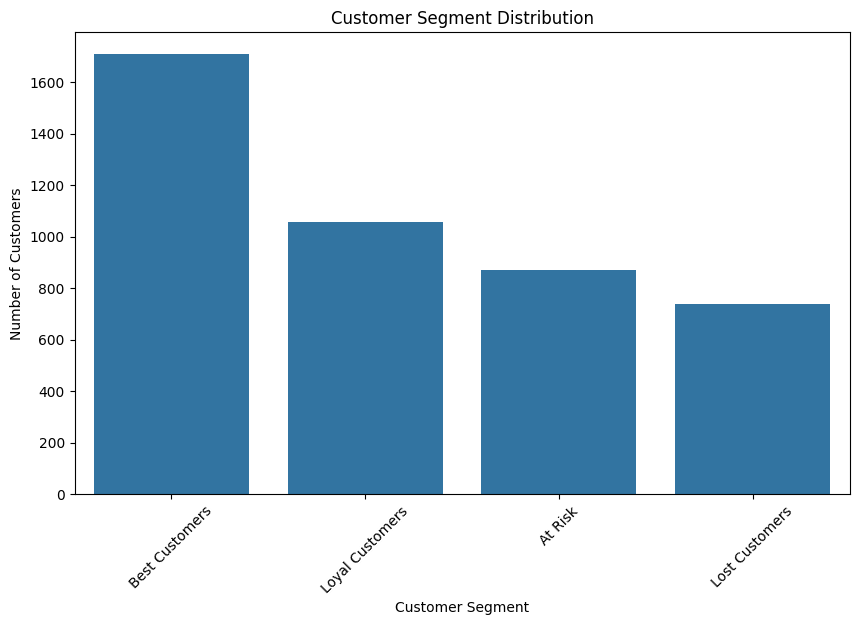

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of customers in each segment
segment_counts = rfm_df['customer_segment'].value_counts().reset_index()
segment_counts.columns = ['customer_segment', 'counts']

# Plot the distribution of customers across different segments
plt.figure(figsize=(10, 6))
sns.barplot(data=segment_counts, x='customer_segment', y='counts')
plt.title('Customer Segment Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

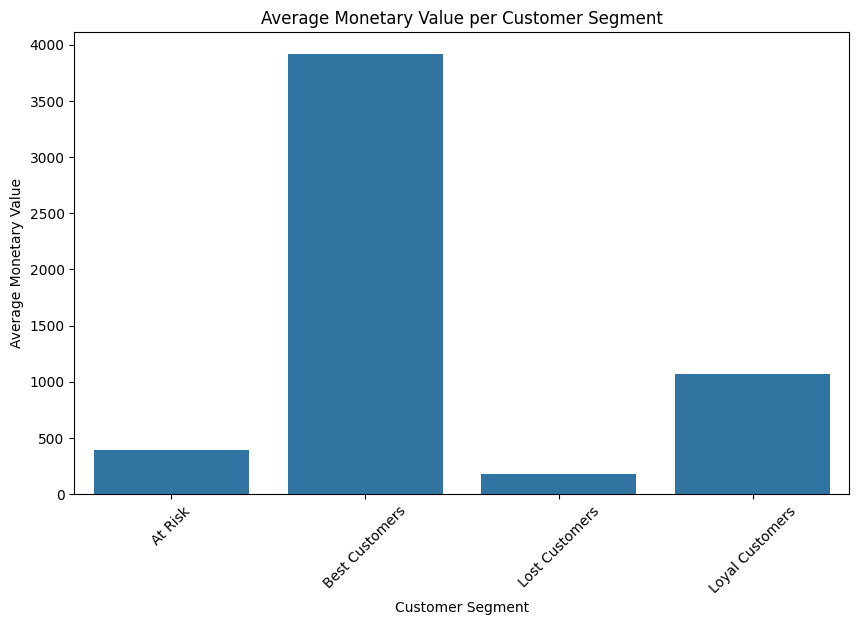

In [62]:
# Calculate average monetary value per segment
avg_monetary_per_segment = rfm_df.groupby('customer_segment')['monetary'].mean().reset_index()

# Plot the average monetary value for each segment
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_monetary_per_segment, x='customer_segment', y='monetary')
plt.title('Average Monetary Value per Customer Segment')
plt.xlabel('Customer Segment')
plt.ylabel('Average Monetary Value')
plt.xticks(rotation=45)
plt.show()

In [63]:
# Rank customers based on spending using SQL window functions
query = """
SELECT CustomerID, monetary,
       RANK() OVER (ORDER BY monetary DESC) AS spending_rank
FROM (
  SELECT CustomerID, SUM(Quantity * UnitPrice) AS monetary
  FROM transactions
  GROUP BY CustomerID
)
"""
rank_df = pd.read_sql(query, conn)

In [65]:
# Identify the most recent transaction for each customer
query = """
SELECT CustomerID, InvoiceNo, InvoiceDate,
       ROW_NUMBER() OVER (PARTITION BY CustomerID ORDER BY InvoiceDate DESC) AS recent_order
FROM transactions
"""
recent_orders_df = pd.read_sql(query, conn)
most_recent_df = recent_orders_df[recent_orders_df['recent_order'] == 1]

# Print the most recent transaction per customer
print(most_recent_df.head())


     CustomerID InvoiceNo          InvoiceDate  recent_order
0       12346.0   C541433  2011-01-18 10:17:00             1
2       12347.0    581180  2011-12-07 15:52:00             1
184     12348.0    568172  2011-09-25 13:13:00             1
215     12349.0    577609  2011-11-21 09:51:00             1
288     12350.0    543037  2011-02-02 16:01:00             1


In [66]:
# Count the number of customers who made their most recent purchase on a particular date
recent_transaction_summary = most_recent_df['InvoiceDate'].value_counts().reset_index()
recent_transaction_summary.columns = ['InvoiceDate', 'number_of_purchases']

# Print the summary
print(recent_transaction_summary.head())

           InvoiceDate  number_of_purchases
0  2011-12-06 09:56:00                    3
1  2011-10-20 14:33:00                    3
2  2011-12-01 13:47:00                    3
3  2011-12-01 15:12:00                    3
4  2011-11-29 15:23:00                    2


<ipython-input-68-63af7e1b6f90>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_recent_df['InvoiceDate'] = pd.to_datetime(most_recent_df['InvoiceDate'])
<ipython-input-68-63af7e1b6f90>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  most_recent_df['InvoiceMonth'] = most_recent_df['InvoiceDate'].dt.to_period('M')


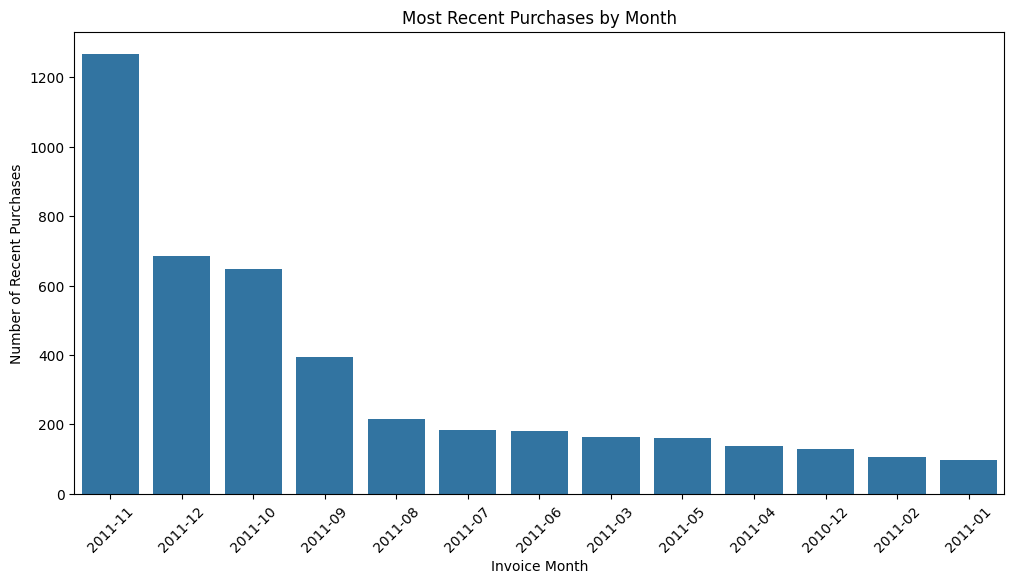

In [68]:
# Convert InvoiceDate to datetime format and extract the month-year for grouping
most_recent_df['InvoiceDate'] = pd.to_datetime(most_recent_df['InvoiceDate'])
most_recent_df['InvoiceMonth'] = most_recent_df['InvoiceDate'].dt.to_period('M')

# Count the number of most recent purchases by month
recent_transaction_summary = most_recent_df['InvoiceMonth'].value_counts().reset_index()
recent_transaction_summary.columns = ['InvoiceMonth', 'number_of_purchases']

# Plot the updated summary
plt.figure(figsize=(12, 6))
sns.barplot(data=recent_transaction_summary, x='InvoiceMonth', y='number_of_purchases')
plt.title('Most Recent Purchases by Month')
plt.xlabel('Invoice Month')
plt.ylabel('Number of Recent Purchases')
plt.xticks(rotation=45)
plt.show()

In [77]:
# Print the column names and first few rows of recent_transaction_summary
print(recent_transaction_summary.columns)
print(recent_transaction_summary.head())

Index(['InvoiceDayOfWeek', 'number_of_purchases'], dtype='object')
  InvoiceDayOfWeek  number_of_purchases
0         Thursday                 1006
1        Wednesday                  771
2          Tuesday                  762
3           Monday                  693
4           Friday                  641


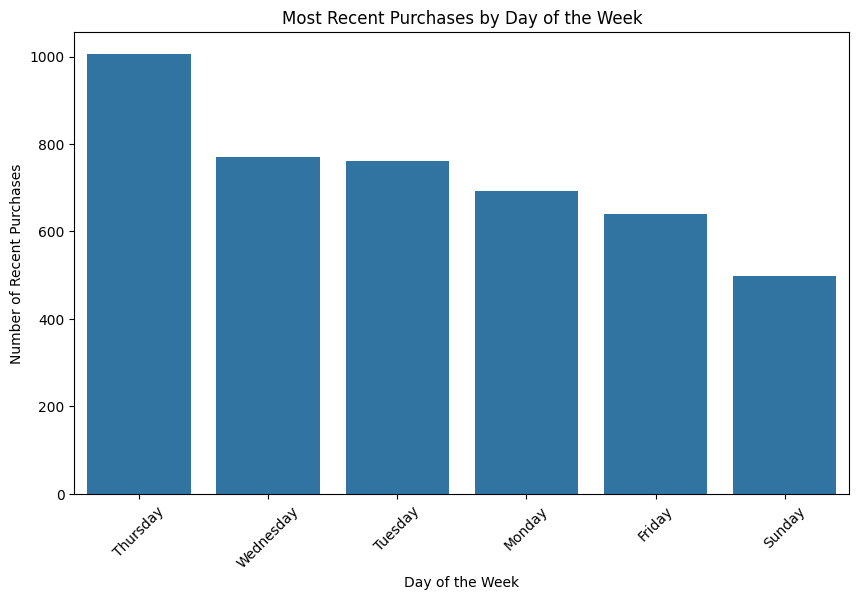

In [79]:
# Plot using the correct column names
plt.figure(figsize=(10, 6))

# Use 'InvoiceDayOfWeek' for the x-axis and 'number_of_purchases' for the y-axis
sns.barplot(data=recent_transaction_summary, x='InvoiceDayOfWeek', y='number_of_purchases')

plt.title('Most Recent Purchases by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Recent Purchases')
plt.xticks(rotation=45)
plt.show()